In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from modelclass import (
    BaseModel, PopModel, UserHistoryModel, MatrixFactorization,
    User2User, ModelEnsemble, Reranker, TwoStageModel,
    catboost_preprocess, get_positive_samples,
    catboost_preprocess_global_test
)


from modelclass import create_pos_memo, get_rank_for_pair_ids, generate_negative_examples
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import polars as pl
import pandas as pd
import dill
import scipy
import time
from __future__ import annotations
from datetime import datetime as dt
import optuna
import sys


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix, coo_matrix
from polars.testing import assert_frame_equal
from typing import Tuple, Iterable, Dict
from scipy import sparse as sp
from loguru import logger
from polars.type_aliases import SchemaDefinition
from numpy.random import shuffle as shuffle_inplace

from abc import ABC, abstractmethod
from scipy.sparse import csr_matrix

In [ ]:
logger.remove() #remove the old handler. Else, the old one will work along with the new one you've added below'
logger.add(sys.stdout, level="DEBUG")

# Functions

In [ ]:
def set_seed(seed: int = 42) -> None:
    import random
    import os

    np.random.seed(seed)
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

    return seed

set_seed()

In [ ]:
def long_to_csr(df: pl.DataFrame) -> (csr_matrix, (np.array, np.array)):
    # Get unique user and item IDs
    users = df['user_id'].unique().to_list()
    items = df['item_id'].unique().to_list()

    # Create mapping from user/item ID to row/column index
    user_to_row = {user: i for i, user in enumerate(users)}
    item_to_col = {item: i for i, item in enumerate(items)}

    # Create data, row indices, and column indices for the CSR matrix
    data = [1] * len(df)
    row_indices = [user_to_row[user] for user in df['user_id']]
    col_indices = [item_to_col[item] for item in df['item_id']]

    # Create the CSR matrix
    csr = csr_matrix((data, (row_indices, col_indices)), 
                     shape=(len(users), len(items)),
                     dtype=np.int8)

    return csr, (np.array(users).flatten(), np.array(items).flatten())

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from typing import List, Tuple, Union

def user_purchases_from_sparse_optimized(sparse_data: Union[csr_matrix, np.ndarray], item_ids: np.ndarray, user_index: int, return_index=False) -> Tuple[np.ndarray, np.ndarray]:
    if isinstance(sparse_data, csr_matrix):
        user_interactions = sparse_data.getrow(user_index)
        user_interactions_dense = user_interactions.toarray().flatten()
    elif isinstance(sparse_data, np.ndarray):
        user_interactions = sparse_data[user_index, :]
        user_interactions_dense = user_interactions.flatten()
    else:
        raise Exception(f"Unexpected type: {type(sparse_data)}")
        
    indices = np.where(user_interactions_dense != 0)[0]
    n_purchases = user_interactions_dense[indices]
    if return_index:
        return indices, n_purchases
    
    item_ids_of_user = item_ids[indices]
    return item_ids_of_user, n_purchases

def all_user_purchases_from_sparse(sparse_data: Union[csr_matrix, np.ndarray], item_ids: np.ndarray, top_k: int = None) -> List[np.ndarray]:
    all_user_purchases = []
    
    for user_index in range(sparse_data.shape[0]):
        item_ids_of_user, n_purchases = user_purchases_from_sparse_optimized(sparse_data, item_ids, user_index)
        
        if top_k is not None:
            if len(n_purchases) > 0:
                # Get the indices of the top k purchases
                top_k_indices = np.argsort(n_purchases)[-top_k:][::-1]
                # Get the top k item ids and their respective purchase counts
                item_ids_of_user = item_ids_of_user[top_k_indices]
            else:
                # If user has no purchases, return an empty array
                item_ids_of_user = np.array([])
        all_user_purchases.append(item_ids_of_user)
    
    return all_user_purchases

In [ ]:
def take_frac_of_data(df: pl.DataFrame, frac = 0.5):
    df = df.sort("user_id")
    return df.head(int(df.shape[0] * frac))

# Load the Data

#### Days:

- train_base - [0;50]
- val_base - [50; 60]
- candidate_predict_set - [60;75] (train_rerank, test_rerank) 
- test_global - [75:90]

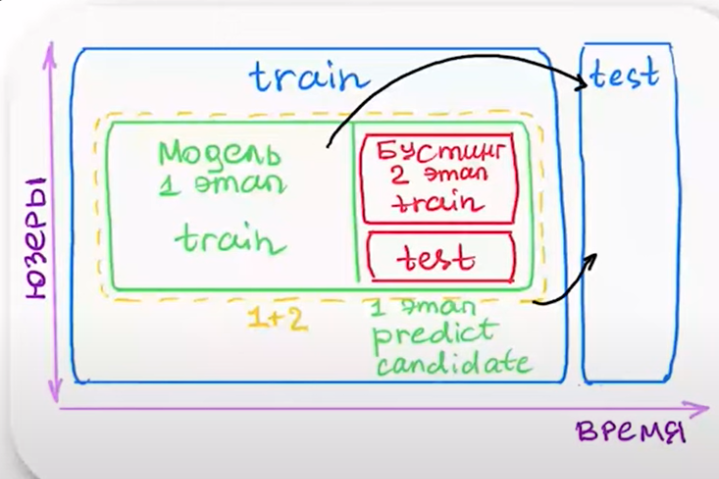

In [ ]:
import os

data_path = "/kaggle/input/wbdata/wb_data"
os.chdir(data_path)

test_global = pl.read_csv('test_global.csv')

# Load train_base, val_base, train_val_base, and candidate_predict_set dataframes
train_base = pl.read_csv('train_base.csv')
val_base = pl.read_csv('val_base.csv')
train_val_base = pl.read_csv('train_val_base.csv')
candidate_predict_set = pl.read_csv('candidate_predict_set.csv')

# Load train_rerank and test_rerank dataframes
train_rerank = pl.read_csv('train_rerank.csv')
test_rerank = pl.read_csv('test_rerank.csv')

In [ ]:
train_base_csr, (trb_user_ids, trb_item_ids) = long_to_csr(train_base)
val_base_csr, (vb_user_ids, vb_item_ids) = long_to_csr(val_base)

In [ ]:
%mkdir /kaggle/ranks_n_models
%cd /kaggle/ranks_n_models

# Evaluation модели с дефолтными гипер-параметрами

- остальное занимает 3ГБ
- MF модель занимает ~12 ГБ RAM
- KNN модель занимает ~10 ГБ RAM


- TOP: 0 minutes
- HISTORY: 0.5 minutes
- MF: 15 minutes
- U2U: 16 minutes


MAP@3:
- PopModel:  0.00542
- UserHistoryModel: 0.092570152380924
- LightFM: 0.09253852315581773
- KNN: 0.10254790153115222

MAP@6: 
- PopModel:  0.00392281
- UserHistoryModel: 0.0611 (0.0696)
- LightFM: 0.0755300552680397
- KNN: 0.07098755123314288

ROC-AUC:
- CatBoostClassifier: 
a) eval: 0.89
b) test:

#### Code to train all base models and validate

In [ ]:
# models1 = {"Popularity Based Model": PopModel()}
# models2 = {"User History Model": UserHistoryModel(chunk_size=100_000)}
# models3 =  {"Matrix Factorization": MatrixFactorization()}
# models4 = {"Matrix Factorization": MatrixFactorization(), "User2User": User2User(n_neighbors=3)}

# for models, evaluate_mf in zip([models1, models2, models3, models4], [False, False, True, False]):
#     ensemble = ModelEnsemble(models, k=3, evaluate_mf=evaluate_mf).fit(train_base_csr, trb_user_ids, trb_item_ids)
#     val_preds = ensemble.predict(vb_user_ids, val_base_csr, trb_item_ids, vb_item_ids)
#     del val_preds, ensemble

# ensemble = ModelEnsemble(k=3).fit(train_base_csr, trb_user_ids, trb_item_ids)
# val_preds = ensemble.predict(vb_user_ids)

## Оценка Reranker

### Сперва нужно обучить ансамбль на train_base + val_base, чтобы получить candidate_prediction_set

### CSR MATRIX

In [ ]:
FRACTION = 0.5

train_val_base_csr, (tvb_user_ids, tvb_item_ids) = long_to_csr(train_val_base)

candidate_predict_set_frac = take_frac_of_data(candidate_predict_set, FRACTION)
cand_pred_csr, (cp_user_ids, cp_item_ids) = long_to_csr(candidate_predict_set_frac)

test_global_frac = take_frac_of_data(test_global, FRACTION)
test_global_csr, (glob_user_ids, glob_item_ids) = long_to_csr(test_global_frac)

# CatBoost

In [ ]:
print(candidate_predict_set.shape, candidate_predict_set_frac.shape)
print(cand_pred_csr.shape)
print(test_global.shape, test_global_frac.shape)
print(test_global_csr.shape)

In [ ]:
knn_est_params = {'n_neighbors': 1, 'metric': 'cosine', 'leaf_size': 50}
mf_est_params = {'no_components': 7, 'learning_rate': 0.05756873225072556, 'max_sampled': 85}

models = {"Popularity Based Model": PopModel(), 
          "User History Model": UserHistoryModel(), 
          "Matrix Factorization": MatrixFactorization(mf_est_params), 
          "User2User": User2User(**knn_est_params) # change on 7
         }  


ensemble_final = ModelEnsemble(models=models).fit(train_val_base_csr, tvb_user_ids, tvb_item_ids)

candidate_preds_frac = ensemble_final.predict(cp_user_ids)

In [ ]:
# candidate_preds["Matrix Factorization"] = np.load("/kaggle/input/mf-train-val/mf_preds_default_train_val.npy")
# candidate_preds["User2User"] = np.load("/kaggle/input/base-model-data/predictions/u2u_preds_k3_train_val.npy")

In [ ]:
users

In [ ]:
users = candidate_predict_set_frac['user_id'].unique()

# Split users into train and test sets
users_train, users_test = train_test_split(users, test_size=0.2, random_state=42)

# Filter the rows of the DataFrame based on the split user sets
df = candidate_predict_set_frac
train_rerank_frac = df.filter(pl.col("user_id").is_in(users_train))
test_rerank_frac = df.filter(pl.col("user_id").is_in(users_test))

ctb_train_users = train_rerank_frac["user_id"]
ctb_test_users = test_rerank_frac["user_id"]

X_train, X_val, y_train, y_val = catboost_preprocess(candidate_preds_frac, candidate_predict_set_frac,
                                                     cp_user_ids, cp_item_ids, ctb_train_users, ctb_test_users)

#### Теперь, чтобы получить X_test, y_test, нужно предсказать ранги global теста.

In [ ]:
# global_test_preds = ensemble_final.predict(glob_user_ids)

# X_test, y_test = catboost_preprocess_global_test(global_test_preds, test_global_frac,glob_user_ids, glob_item_ids)

### Обучаем CatBoost

In [ ]:
import os
import dill
from catboost import CatBoostClassifier

# Path to the model file
model_path = '/kaggle/input/catboost_fin_1500_25-05/other/ctb_model_25-05_1500_est/1/ctb_model_1500_est_25_05.dill'

# Check if the model file exists
if os.path.exists(model_path):
    # Load the model using dill
    with open(model_path, 'rb') as f:
        ctb_model = dill.load(f)
    
    # Ensure the loaded object is a CatBoostClassifier
    if isinstance(ctb_model, CatBoostClassifier):
        print("Model loaded successfully.")
    else:
        print("Loaded object is not a CatBoostClassifier.")
else:
    print("Model file does not exist.")
    ctb_model = Reranker(n_estimators=1500).fit(X_train, X_val, y_train, y_val)
    ctb_model.save()
    !mv ctb_model.dill /kaggle/working

y_pred = ctb_model.predict_proba(X_val)

#### Если хотим, можем даже уместить все в удобный интерфейс TwoStageModel:

In [ ]:
"""

from sklearn.metrics import roc_auc_score

two_stage_model = TwoStageModel(ensemble, ctb_model)
preds_2stage = two_stage_model.predict(trb_user_ids[:10])
preds_2stage


print(f"ROC AUC score (Validation) = {roc_auc_score(y_val, y_pred):.3f}")
y_pred = ctb_model.predict_proba(X_test)
print(f"ROC AUC score (Global Test) = {roc_auc_score(y_test, y_pred):.3f}")

"""

### ROC AUC (val): 0.88

### ROC AUC (generated test): 0.8

# Оптимизация гипер-параметров

В PopModel и UserHistoryModel нет ГП (хотя можно было бы добавить нелинейную функцию в UserHistoryModel для определения влияния множественной покупки одного айтема несколько раз, например полиномиал). Следовательно, требуется оптимизировать работу MatrixFactorization и User2User KNN модели.

## MatrixFactorization (LightFM)

In [ ]:
K = 3

def objective(trial):
    # no_components=10, k=5, n=10, learning_schedule='adagrad', 
    # loss='logistic', learning_rate=0.05, rho=0.95, epsilon=1e-06, 
    # item_alpha=0.0, user_alpha=0.0, max_sampled=10, random_state=None
    
    params = {
        "no_components": trial.suggest_int('no_components', 5, 15, step=2),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        "max_sampled": trial.suggest_int('max_sampled', 5, 100, step=20),
    }

    mf_model = MatrixFactorization(**params)

    mf_model.fit(train_base_csr, user_ids=trb_user_ids, item_ids=trb_item_ids)
    preds = mf_model.predict(vb_user_ids)
    
    map_score = ModelEnsemble.evaluate(preds, val_base_csr, 
                  trb_item_ids, vb_item_ids, k=K)

    return 1 - map_score  # Optuna minimizes the objective, so we use 1 - MAP@K for maximization

"""
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

print('Best trial of MF:')
print(f'  MAP@{K}: ', 1 - study.best_trial.value)  # Convert back to AUC ROC
print('  Params: ')
best_params = study.best_trial.params.items()

for key, value in best_params:
    print(f'    {key}: {value}')
""" 

[I 2024-05-21 01:59:20,727] Trial 0 finished with value: 0.9033793842447264 and parameters: {'no_components': 15, 'learning_rate': 0.08426323644636675, 'max_sampled': 45}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 02:29:14,190] Trial 1 finished with value: 0.9110863720956309 and parameters: {'no_components': 11, 'learning_rate': 0.006774699971854338, 'max_sampled': 65}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 02:58:31,115] Trial 2 finished with value: 0.9110866201679847 and parameters: {'no_components': 9, 'learning_rate': 0.006143857187630623, 'max_sampled': 25}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 03:28:25,368] Trial 3 finished with value: 0.9058128810081263 and parameters: {'no_components': 11, 'learning_rate': 0.024229674337371856, 'max_sampled': 65}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 03:59:09,200] Trial 4 finished with value: 0.9110863720956309 and parameters: {'no_components': 13, 'learning_rate': 0.006553447591708457, 'max_sampled': 5}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 04:27:52,270] Trial 5 finished with value: 0.9110887287829917 and parameters: {'no_components': 7, 'learning_rate': 0.004459152379566283, 'max_sampled': 85}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 04:59:47,787] Trial 6 finished with value: 0.9110863720956309 and parameters: {'no_components': 15, 'learning_rate': 0.0031211674733399026, 'max_sampled': 45}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 05:29:22,701] Trial 7 finished with value: 0.9107694286546392 and parameters: {'no_components': 7, 'learning_rate': 0.08981717719739438, 'max_sampled': 25}. Best is trial 0 with value: 0.9033793842447264.

[I 2024-05-21 06:01:33,230] Trial 8 finished with value: 0.898713453360661 and parameters: {'no_components': 15, 'learning_rate': 0.05756873225072556, 'max_sampled': 85}. Best is trial 8 with value: 0.898713453360661.

[I 2024-05-21 06:33:48,354] Trial 9 finished with value: 0.8993813571641559 and parameters: {'no_components': 15, 'learning_rate': 0.02607459598756857, 'max_sampled': 45}. Best is trial 8 with value: 0.898713453360661.

Best trial of MF:
  MAP@3:  0.101286546639339
  Params: 
    no_components: 15
    learning_rate: 0.05756873225072556
    max_sampled: 85

## KNN

In [ ]:
def objective(trial):
    # Define the search space for KNN hyperparameters
    params = {
        "n_neighbors": trial.suggest_int('n_neighbors', 3, 10, step=2),
        "leaf_size": trial.suggest_int('leaf_size', 30, 50, step=5),
        "metric": trial.suggest_categorical('metric', ['cosine', 'minkowski']),
#         "p": trial.suggest_categorical("p", [1,2,3]),
    }


    # Instantiate the custom KNN model
    model = User2User(**params)

    # Fit the KNN model with the user embeddings
    knn_model.fit(train_base_csr, trb_item_ids, trb_user_ids, user_embeddings)

    # Predict with KNN model
    preds = knn_model.predict(vb_user_ids)
    
    # Evaluate the model 
    map_score = ModelEnsemble.evaluate(preds, val_base_csr, 
                  trb_item_ids, vb_item_ids, k=3)

    return 1 - map_score  # Optuna minimizes the objective, so we use 1 - MAP@K for maximization

"""
models3 =  {"Matrix Factorization": MatrixFactorization()}
ensemble = ModelEnsemble(models3).fit(train_base_csr, trb_user_ids, trb_item_ids)
user_embeddings = ensemble.mf_model.get_latent_users()

# Create a study object and optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

# Print the best hyperparameters and result
print('Best trial of KNN:')
print('  MAP@k: ', 1 - study.best_trial.value)  # Convert back to AUC ROC
print('  Params: ')
best_params = study.best_trial.params.items()

for key, value in best_params:
    print(f'    {key}: {value}')
"""

2403.1s	30	[I 2024-05-21 20:31:01,365] Trial 0 finished with value: 0.9202711046314612 and parameters: {'n_neighbors': 3, 'leaf_size': 35, 'metric': 'minkowski', 'p': 2}. Best is trial 0 with value: 0.9202711046314612.

5880.9s	48	[I 2024-05-21 21:28:59,167] Trial 1 finished with value: 0.9160920247343022 and parameters: {'n_neighbors': 7, 'leaf_size': 50, 'metric': 'minkowski', 'p': 2}. Best is trial 1 with value: 0.9160920247343022.

14363.4s	66	[I 2024-05-21 23:50:21,901] Trial 2 finished with value: 0.9130033499690653 and parameters: {'n_neighbors': 7, 'leaf_size': 45, 'metric': 'minkowski', 'p': 1}. Best is trial 2 with value: 0.9130033499690653.

17540.2s	84	[I 2024-05-22 00:43:18,719] Trial 3 finished with value: 0.9170842632945696 and parameters: {'n_neighbors': 5, 'leaf_size': 35, 'metric': 'minkowski', 'p': 2}. Best is trial 2 with value: 0.9130033499690653.

34191.0s	102	[I 2024-05-22 05:20:49,244] Trial 4 finished with value: 0.9216541138954752 and parameters: {'n_neighbors': 9, 'leaf_size': 35, 'metric': 'cosine', 'p': 3}. Best is trial 2 with value: 0.9130033499690653.

36794.4s	120	[I 2024-05-22 06:04:12,646] Trial 5 finished with value: 0.9202711046314612 and parameters: {'n_neighbors': 3, 'leaf_size': 45, 'metric': 'minkowski', 'p': 2}. Best is trial 2 with value: 0.9130033499690653.




21530.7s	69	[I 2024-05-21 23:56:00,591] Trial 0 finished with value: 0.9227124683893804 and parameters: {'n_neighbors': 7, 'leaf_size': 45, 'metric': 'cosine', 'p': 1}. Best is trial 0 with value: 0.9227124683893804.

39328.5s	87	[I 2024-05-22 04:52:38,455] Trial 1 finished with value: 0.9227124683893804 and parameters: {'n_neighbors': 7, 'leaf_size': 40, 'metric': 'cosine', 'p': 1}. Best is trial 0 with value: 0.9227124683893804.

In [ ]:
"""
models3 =  {"Matrix Factorization": MatrixFactorization()}
ensemble = ModelEnsemble(models3).fit(train_base_csr, trb_user_ids, trb_item_ids)
mf_model = ensemble.mf_model

models4 = {"User2User": User2User(**knn_est_params)}
ensemble = ModelEnsemble(models4).fit(train_base_csr, trb_user_ids, trb_item_ids)
ensemble.mf_model = mf_model

# Fit the KNN model with the user embeddings
ensemble.fit(train_base_csr, trb_user_ids, trb_item_ids)
preds = ensemble.predict(vb_user_ids, val_base_csr, trb_item_ids, vb_item_ids)
"""

## Оптимизация CatBoost

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'thread_count': 20,  
        'random_state': 42,
        'verbose': 200,      
    }

    #X_train, X_val, y_train, y_val - should be obtained beforehand 
    
    # Initialize CatBoost model, fit, predict, score
    model = Reranker(**params)
    model.fit(X_train, X_val, y_train, y_val)
    preds = model.predict_proba(X_val)
    auc_score = roc_auc_score(y_val, preds)

    return 1 - auc_score  # Optuna minimizes the objective, so we use 1 - AUC for maximization

"""
# Create and optimize study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best trial results
print('Best trial of CatBoost:')
print(f'  AUC ROC: ', 1 - study.best_trial.value)  # Convert back to AUC ROC
print('  Params: ')
best_params = study.best_trial.params.items()

for key, value in best_params:
    print(f'    {key}: {value}')
"""


[I 2024-05-22 00:17:59,051] Trial 0 finished with value: 0.143691908787545 and parameters: {'subsample': 0.8746524969398852, 'max_depth': 4, 'n_estimators': 1000, 'learning_rate': 0.017610282881683197}. Best is trial 0 with value: 0.143691908787545.

[I 2024-05-22 00:24:38,375] Trial 1 finished with value: 0.12340488839600572 and parameters: {'subsample': 0.6493933232357054, 'max_depth': 5, 'n_estimators': 1100, 'learning_rate': 0.09618289423795023}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:25:56,759] Trial 2 finished with value: 0.16856510342341668 and parameters: {'subsample': 0.8813710433330093, 'max_depth': 5, 'n_estimators': 200, 'learning_rate': 0.0019009213871924655}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:28:00,391] Trial 3 finished with value: 0.15328928358011296 and parameters: {'subsample': 0.5799425242723604, 'max_depth': 3, 'n_estimators': 400, 'learning_rate': 0.025164913566055852}. Best is trial 1 with value: 0.12340488839600572.
Click to show javascript error.

[I 2024-05-22 00:30:31,970] Trial 4 finished with value: 0.13907588539617755 and parameters: {'subsample': 0.6176757925564924, 'max_depth': 6, 'n_estimators': 400, 'learning_rate': 0.038845104725539585}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:37:27,482] Trial 5 finished with value: 0.15114568817295215 and parameters: {'subsample': 0.6558510820264669, 'max_depth': 3, 'n_estimators': 1300, 'learning_rate': 0.009781822980498551}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:37:50,020] Trial 6 finished with value: 0.1602483322273618 and parameters: {'subsample': 0.5472816367854844, 'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.02314044535023668}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:43:05,878] Trial 7 finished with value: 0.13929749599313734 and parameters: {'subsample': 0.6643941934619915, 'max_depth': 3, 'n_estimators': 1000, 'learning_rate': 0.04538211423566563}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:44:33,633] Trial 8 finished with value: 0.15691123569991072 and parameters: {'subsample': 0.5191486163919342, 'max_depth': 9, 'n_estimators': 200, 'learning_rate': 0.006362677799266338}. Best is trial 1 with value: 0.12340488839600572.

[I 2024-05-22 00:52:25,136] Trial 9 finished with value: 0.13853985478845843 and parameters: {'subsample': 0.5774392227914467, 'max_depth': 10, 'n_estimators': 900, 'learning_rate': 0.00904660857625249}. Best is trial 1 with value: 0.12340488839600572.

Скорее всего нужно больше n_estimators

```
Best trial of CatBoost:
  AUC ROC:  0.8765951116039943
  Params: 
    subsample: 0.6493933232357054
    max_depth: 5
    n_estimators: 1100
    learning_rate: 0.09618289423795023
```

In [ ]:
ctb_est_params = {"subsample": 0.6493933232357054, "max_depth": 5, "n_estimators": 1100, "learning_rate": 0.09618289423795023}

# Анализ Качества После Подбора ГП

| Модель       | дефолт качество на val | optuna + качество на val | optuna + качество на global test |
|--------------|----------------------------|--------------------------|----------------------------------|
| PopModel MAP@3 | 0.005                      | NaN                      | 0.027                          |
| UserHistory MAP@3 | 0.09                      | NaN                      | 0.075                           |
| LightFM MAP@3 | 0.092                      | 0.1                      | 0.068                            |
| User2User MAP@3 | 0.1                      | 0.087                       | 0.073                                |
| Catboost ROC-AUC | 0.88                      | 0.88                      |      0.81                           |
| TwoStage |  Nan  |  Nan  |  0.147  | 

## Pop & History global Test

In [ ]:
del  candidate_preds_frac

In [ ]:
warm_glob_user_ids = glob_user_ids[np.isin(glob_user_ids, tvb_user_ids)]
print(glob_user_ids.shape, warm_glob_user_ids.shape)

mask = np.isin(glob_user_ids, warm_glob_user_ids)
warm_test_global_csr = test_global_csr[mask]
test_global_csr.shape, warm_test_global_csr.shape

In [ ]:
ensemble_final.models["User History Model"].train_data.shape

In [ ]:
# %%script echo skipping
"""
models =  {"Popularity Based Model": PopModel(), "User History Model": UserHistoryModel()}
ensemble = ModelEnsemble(models, k=3).fit(train_val_base_csr, tvb_user_ids, tvb_item_ids)
test_preds = ensemble.predict(
    warm_glob_user_ids, warm_test_global_csr, 
    tvb_item_ids, glob_item_ids
)
"""

## LightFM global Test

In [ ]:
# %%script echo skipping
mf_est_params = {"no_components": 15, "learning_rate": 0.0575687322507, "max_sampled": 85}

"""
models =  {"Matrix Factorization": MatrixFactorization(**mf_est_params)}
ensemble = ModelEnsemble(models, k=3).fit(train_val_base_csr, tvb_user_ids, tvb_item_ids)
test_preds = ensemble.predict(
    warm_glob_user_ids, warm_test_global_csr, 
    tvb_item_ids, glob_item_ids
)
"""

### U2U global Test

In [ ]:
# %%script echo skipping

"""
models =  {"Matrix Factorization": MatrixFactorization(), "User2User": User2User(**knn_est_params)}
ensemble = ModelEnsemble(models, k=3, evaluate_mf=False).fit(train_val_base_csr, tvb_user_ids, tvb_item_ids)
test_preds = ensemble.predict(
    warm_glob_user_ids, warm_test_global_csr, 
    tvb_item_ids, glob_item_ids
)
"""

### CatBoost Global Test

### ROC-AUC: 0.81 

In [ ]:
reranker_model = Reranker()
reranker_model.ctb_model = ctb_model

In [ ]:
two_stage_model = TwoStageModel(ensemble_final, reranker_model)

first_n = 200_000

preds = two_stage_model.predict(warm_glob_user_ids[:first_n])

In [ ]:
# np.save('final_predictions.npy', preds)
# !mv final_predictions.npy /kaggle/working/final_predictions.npy

In [ ]:
preds.shape, warm_glob_user_ids[:first_n].shape

In [ ]:
tvb_item_ids.shape, glob_item_ids.shape

In [ ]:
ModelEnsemble.evaluate(preds, warm_glob_user_ids[:first_n], tvb_item_ids, glob_item_ids)

# Анализ Признаков

## CatBoost

In [ ]:
del test_preds, preds, candidate_preds_frac

In [ ]:
import shap
from catboost import Pool

X_train_subs, _, y_train_subs, __ = train_test_split(X_train, y_train,
                                                     test_size=0.9,
                                                     random_state=42)

shap_values = ctb_model.ctb_model.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=[]), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

In [ ]:
plt.title("Влияние рангов моделей первого уровня на train")

shap.summary_plot(
    shap_values,
    X_train_subs,
    feature_names=["PopModel", "UserHistory", "LightFM", "LFM+KNN"]
)